In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from PIL import Image
import os
from contextlib import redirect_stdout
import ssl

import matplotlib.pyplot as plt

ssl._create_default_https_context = ssl._create_unverified_context

# Datasets

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

def getMeanSTD(path):
    if os.path.exists(path + '.DS_Store'):
        os.remove(path + '.DS_Store')

    image_paths = [os.path.join(path, img) for img in os.listdir(path)]

    mean_sum = torch.zeros(3)
    std_sum = torch.zeros(3)

    for img_path in image_paths:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img)
        mean_sum += img_tensor.mean(dim=(1, 2))
        std_sum += img_tensor.std(dim=(1, 2))

    mean = mean_sum / len(image_paths)
    std = std_sum / len(image_paths)

    mean = mean.tolist()
    std = std.tolist()

    return mean, std

all_path = '../data/processed/Combined/All/'
all_mean, all_std = getMeanSTD(all_path)
print("Train Mean:", all_mean)
print("Train Standard deviation:", all_std)

Train Mean: [0.3101806044578552, 0.31018245220184326, 0.3101660907268524]
Train Standard deviation: [0.19360092282295227, 0.1936030238866806, 0.19359245896339417]


In [3]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=all_mean, std=all_std),
])

dataset_path = '../data/processed/Combined/Classes/'

if os.path.exists(dataset_path + '.DS_Store'):
        os.remove(dataset_path + '.DS_Store')

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [4]:
total_size = len(dataset)
train_size = int(0.72 * total_size)
val_size = int(0.08 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Loading & Modifying ResNet-50 Model

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

with redirect_stdout(None):
    model.eval()

Using cache found in /Users/ahmedmahmoud/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/ahmedmahmoud/Desktop/Uni/Semester 8/GP24_Ahmed_EmbeddedBreastCancer/Code/breast-cancer-diagnosis/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ahmedmahmoud/Desktop/Uni/Semester 8/GP24_Ahmed_EmbeddedBreastCancer/Code/breast-cancer-diagnosis/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
num_features = model.fc.in_features
num_features

2048

In [7]:
num_classes = 2
new_fc_layers = [
    torch.nn.Linear(num_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(256, num_classes)
]
model.fc = torch.nn.Sequential(*new_fc_layers)

In [14]:

batch_size = 16
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
model = model.to('mps')
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('mps'), labels.to('mps')
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('mps'), labels.to('mps')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Train Loss: 0.7258, Validation Loss: 23.3434, Validation Accuracy: 64.81%
Epoch [2/10], Train Loss: 0.5790, Validation Loss: 0.8027, Validation Accuracy: 72.22%
Epoch [3/10], Train Loss: 0.6126, Validation Loss: 0.7798, Validation Accuracy: 68.52%
Epoch [4/10], Train Loss: 0.6101, Validation Loss: 0.7066, Validation Accuracy: 66.67%
Epoch [5/10], Train Loss: 0.5368, Validation Loss: 1.3724, Validation Accuracy: 70.37%
Epoch [6/10], Train Loss: 0.5279, Validation Loss: 0.9654, Validation Accuracy: 70.37%
Epoch [7/10], Train Loss: 0.4716, Validation Loss: 0.4959, Validation Accuracy: 68.52%
Epoch [8/10], Train Loss: 0.3644, Validation Loss: 0.6151, Validation Accuracy: 72.22%
Epoch [9/10], Train Loss: 0.4234, Validation Loss: 1.0282, Validation Accuracy: 72.22%
Epoch [10/10], Train Loss: 0.3885, Validation Loss: 1.1601, Validation Accuracy: 72.22%


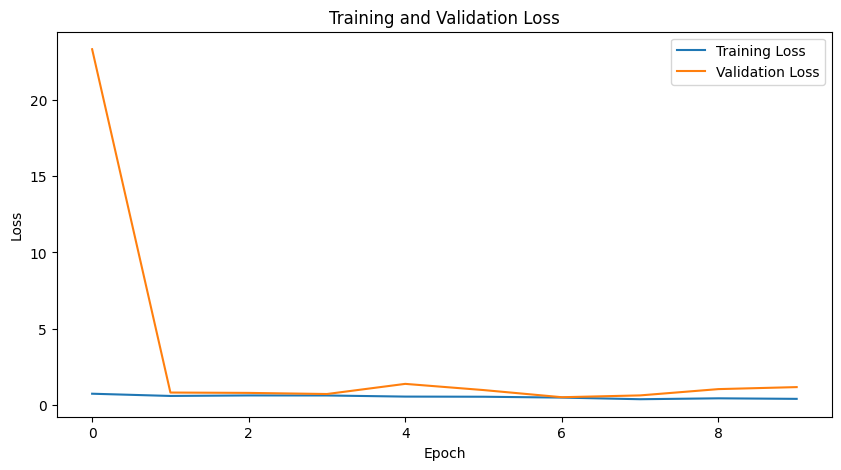

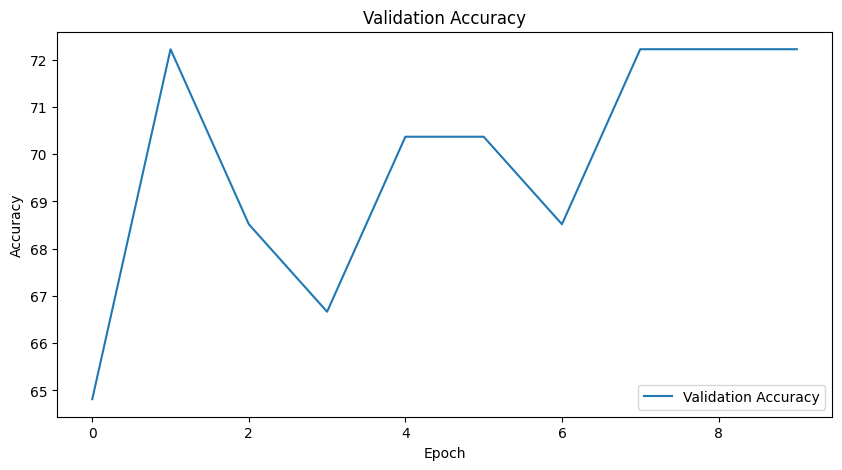

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [17]:
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to('mps'), labels.to('mps')
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.6715, Test Accuracy: 81.02%
